# Model Evaluation & Registry
## Evaluate model metrics & Create artiacts for trained models

This notebook is about computing model metrics and generating model artifacts to setup form model validation and then delivery.
The main sections are the following:

1. [Configure Model Evaluation as a SageMaker Processing Job](#1.1)
2. [Register Model as review Validation Status](#1.2)
3. [Deploy model to SageMaker endpoint](#1.3)

These steps are performed individually for now, but will be wrapped into SageMaker pipelines later on.

Let' start by configuring the Sagemaker Session.


In [2]:
import os
import sagemaker
import logging
import boto3
import time
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## 1. Evaluate & Register `SKLearn` Models

Once the model is trained, evaluation metrics from the test dataset need to be computed. To do so, the hlodout dataset and the model artifacts need to b eretrieved from the S3 bucket, serving as inuputs to a SageMaker Processing Job.

### 1.1 Configure model evaluation as a SageMaker Processing Job
The processing job will execute the `evaluate_model_metrics.py` script and return the results under several formats (figures, tables, jsons). Please note that the metrics computed and returned in json format are useful for model registry and, later on, in end-to-end pipelines.

![Model_evaluation](./img/aws_model_evaluation.png)

The Sagemaker Processing Job retrieves the model artifacts and the test data as local resources in the processing image. The processing parameters are detailed in the next section.

#### 1.1.1 Configure Processing Parameters
Processing parameters include the compute instance information along with the Model and test data S3 locations. 



In [3]:
# ========================== Processing parameters ==========================
FRAMEWORK_VERSION = '1.2-1'
instance_type = 'ml.t3.medium'
instance_count = 1

model_s3_uri = 's3://{}/sagemaker-scikit-lea-240604-1642-002-59cbda6b/output/'.format(bucket)
test_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2024-03-06-21-05-51-569/output/bank-churn-test/'.format(bucket)


#### 1.1.2 Configure Pocessing Inputs & Outputs

Here, the local files are configured as several `ProcessingInputs`. They are also passed as processing arguments to offer more flexibility in the local files management.

In [4]:
from sagemaker.processing import ProcessingInput, ProcessingOutput


input_model = '/opt/ml/processing/input/model'
input_data = '/opt/ml/processing/input/data'
output_data = '/opt/ml/processing/output'


# ========================== Processing inputs ==========================
processing_inputs = [
    #### Trained model ####
    ProcessingInput(input_name= 'model',
                    source=model_s3_uri,
                    destination=input_model),
    
    #### Test subset ####
    ProcessingInput(input_name='testSubset',
                    source=test_data_s3_uri,
                    destination=input_data)
]


# ========================== Processing outputs ==========================
processing_outputs = [
    ProcessingOutput(output_name='metrics',
                     source=output_data,
                     s3_upload_mode='EndOfJob')

]


# ========================== Processing arguments ==========================
processing_args=[
    '--input-model', str(input_model),
    '--input-data', str(input_data),
    '--output-data', str(output_data)
]


#### 1.1.3 Instanciate `SKLearn` Processor


In [5]:
from sagemaker.sklearn.processing import SKLearnProcessor


evaluation_processor = SKLearnProcessor(
    framework_version=FRAMEWORK_VERSION,
    instance_type=instance_type,
    instance_count=instance_count,
    env={'AWS_DEFAULT_REGION': region},
    role=role,
)


#### 1.1.4 Run processor to perform model evaluation

In [6]:
evaluation_processor.run(
    code='src/evaluate_metrics.py',
    inputs=processing_inputs,
    outputs=processing_outputs,
    arguments=processing_args,
    wait=True
)


INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-06-27-09-09-25-613


..........................................................................................Collecting matplotlib==3.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━

#### 1.1.5 Review Processing Job

In [7]:
from pprint import pprint

processing_job_name = evaluation_processor.latest_job.describe()['ProcessingJobName']
pprint(evaluation_processor.latest_job.describe(), compact=True)

{'AppSpecification': {'ContainerArguments': ['--input-model',
                                             '/opt/ml/processing/input/model',
                                             '--input-data',
                                             '/opt/ml/processing/input/data',
                                             '--output-data',
                                             '/opt/ml/processing/output'],
                      'ContainerEntrypoint': ['python3',
                                              '/opt/ml/processing/input/code/evaluate_metrics.py'],
                      'ImageUri': '659782779980.dkr.ecr.eu-west-3.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3'},
 'CreationTime': datetime.datetime(2024, 6, 27, 9, 9, 26, 180000, tzinfo=tzlocal()),
 'Environment': {'AWS_DEFAULT_REGION': 'eu-west-3'},
 'LastModifiedTime': datetime.datetime(2024, 6, 27, 9, 25, 46, 475000, tzinfo=tzlocal()),
 'ProcessingEndTime': datetime.datetime(2024, 6, 27, 9, 25, 46, 60000, tzinfo=

#### 1.1.6 Review model metrics
Retrieve model metrics from S3 bucket and copy to local environment.

In [8]:
fig_name = 'confusion_roc_auc.png'
dic_name = 'evaluation.json'

metrics_s3_uri = evaluation_processor.latest_job.outputs[0].destination
metrics_jpg_s3_uri = os.path.join(metrics_s3_uri, fig_name)
metrics_dic_s3_uri = os.path.join(metrics_s3_uri, dic_name)


print(metrics_jpg_s3_uri)
print(metrics_dic_s3_uri)

s3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-27-09-09-25-613/output/metrics/confusion_roc_auc.png
s3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2024-06-27-09-09-25-613/output/metrics/evaluation.json


In [9]:
!aws s3 cp f's3://{bucket}/{processing_job_name}/output/metrics/metrics/confusion_roc_auc.png' './metrics/confusion.jpg'


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `aws s3 cp 's3://{}/{}/output/metrics/metrics/confusion_roc_auc.png'.format(bucket, processing_job_name) './metrics/confusion.jpg''


In [10]:
!aws s3 cp 's3://{}/{}/output/metrics/metrics/confusion_roc_auc.png'.format(bucket, processing_job_name) './metrics/eval.json'


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `aws s3 cp 's3://{}/{}/output/metrics/metrics/confusion_roc_auc.png'.format(bucket, processing_job_name) './metrics/eval.json''


In [11]:
dic_corrected_s3_uri = "s3://{}/{}/output/metrics/metrics/evaluation.json".format(bucket, processing_job_name)
evaluation_json = sagemaker.s3.S3Downloader.read_file(dic_corrected_s3_uri)


pprint(json.loads(evaluation_json))

{'metrics': {'accuracy': {'value': 1.0}, 'f1_score': {'value': 1.0}}}


### 1.2 Register model to prepare for inference
Model artifacts are generated and stored after training. In this section, artifacts are retrieved and the model is registered for approval. Information on the instance can also be passed. It will be needed later when working with SageMaker Pipelines.

#### 1.2.1 Configure workflow parameters

In [12]:
from sagemaker.workflow.parameters import ParameterString, ParameterInteger


model_approval_status = ParameterString(
    name='ApprovalStatus',
    default_value='PendingManualApproval'
)


deploy_instance_type = ParameterString(
    name='DeployInstanceType',
    default_value='ml.m5.large'
)


deploy_instance_count = ParameterInteger(
    name='DeployInstanceCount',
    default_value=1
)


#### 1.2.2  Configure the model package group name
The model package group will contain the model versions with their approval status, metrics and other details.

In [13]:
import time


model_package_group_name = f'Bank-Churn-prediction-{int(time.time())}'
print(model_package_group_name)

Bank-Churn-prediction-1719480385


#### 1.2.3 configure model metrics source file.
Point to the `json` metrics files generated and saved during model evaluation step.

In [14]:
from sagemaker.model_metrics import ModelMetrics, MetricsSource


model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="s3://{}/{}/output/metrics/metrics/evaluation.json".format(bucket, processing_job_name),
        content_type="text/csv"
    )
)

print(model_metrics.model_statistics)

#### 1.2.4 Configure the model registry from the saved model
Start by instanciating an `SKLearn` model. This is one way to to so. An other way is to create the model from the `SKLearn` estimator, and then to perform the registry.

In [15]:
from sagemaker.sklearn.model import SKLearnModel


PY_VERSION= 'py3'

sklearn_model = SKLearnModel(
    entry_point='src/inference.py',
    model_data=model_s3_uri+'model.tar.gz',
    framework_version=FRAMEWORK_VERSION,
    py_version=PY_VERSION,
    role=role,  
) 

In this case, the model is set to accept tabular data. Therefore, content and response types are configured to be `text/csv`. Model metrics and package group name are also passed as parameters to `.register()` method. 

Approval status can be set & modified whether manually or programatically. This step is not shown in this notebook.

In [16]:
sklearn_model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    model_package_group_name=model_package_group_name,
    model_metrics=model_metrics,
    #approval_status=model_approval_status,
    #inference_instances=[deploy_instance_type],
    #transform_instances=[deploy_instance_type],
)


INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


### 1.3 Create endpoint to perform inference

The last step is to configure and create the endpoint in order to serve new predictions. In this configuration, we assume the model will serve near real-time predictions. Another case is when no real-time predictions are needed. Configuring a `BatchTransformJob` is more suitable for this scenario.

Working with custom scripts, `inference.py` source code is executed as an entry point to generate predictions. This code must contain SageMaker functions `model_fn()` and `predict_fn()` to load the model and compute predictions, respectively.  

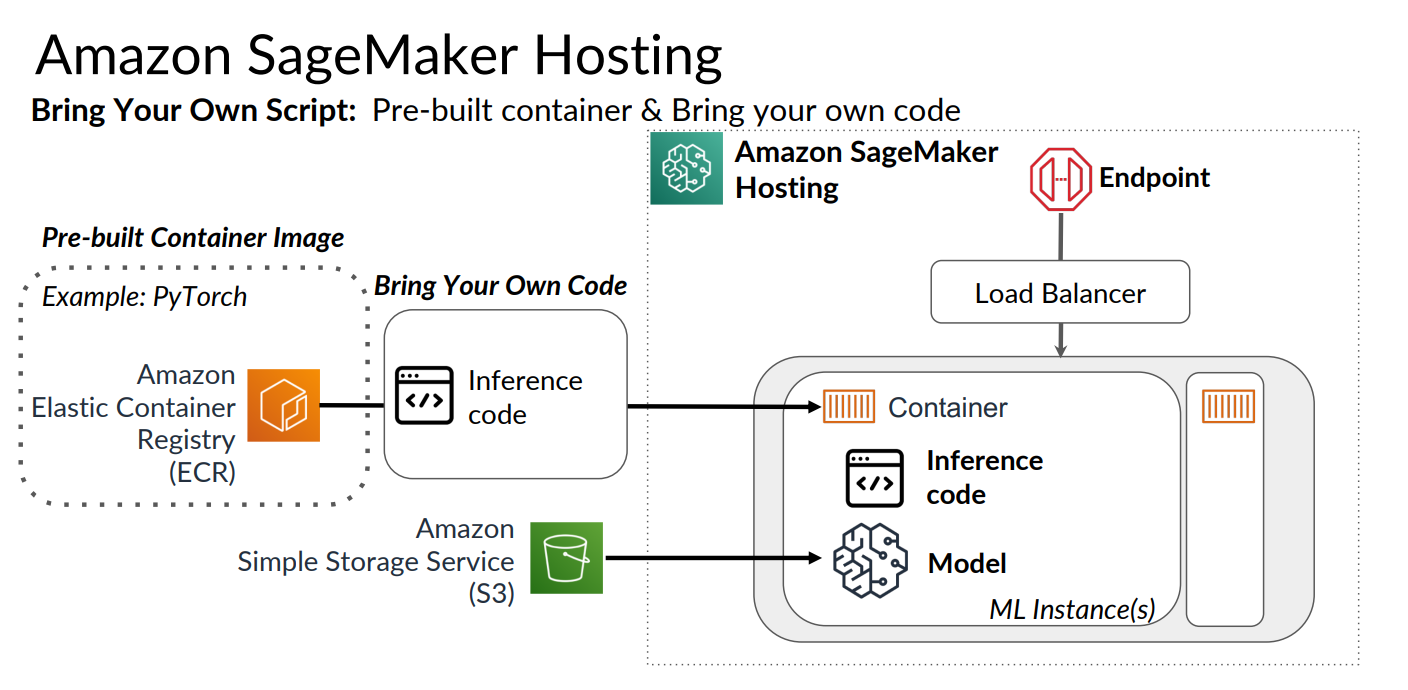


Start by creating a SageMaker model from the `SKLearn` model instance. The instance type is among the parameters that can be passed to this method. Then, the model is deployed to a SageMaker Endpoint, with the instance configuration passed in parameters.

In [17]:
sklearn_model.create(
    instance_type=instance_type
)


INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-06-27-09-26-27-214


In [18]:
sklearn_model.deploy(
    initial_instance_count=instance_count,
    instance_type='ml.m5.large',
    wait=True
)


INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-06-27-09-26-27-961
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-06-27-09-26-31-969
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-06-27-09-26-31-969


------!

### 1.4 Cleanup resources

In [22]:
from pprint import pprint

# Specify the name of the endpoint
endpoint_name = sklearn_model.endpoint_name
print(endpoint_name)


# Store DescribeEndpointConfig response into a variable that we can index in the next step.
response = sm.describe_endpoint_config(EndpointConfigName=endpoint_name)
pprint(response)


# Delete endpoint
model_name = response['ProductionVariants'][0]['ModelName']
print(model_name)

sagemaker-scikit-learn-2024-06-27-09-26-31-969
{'CreationTime': datetime.datetime(2024, 6, 27, 9, 26, 32, 281000, tzinfo=tzlocal()),
 'EnableNetworkIsolation': False,
 'EndpointConfigArn': 'arn:aws:sagemaker:eu-west-3:668303144976:endpoint-config/sagemaker-scikit-learn-2024-06-27-09-26-31-969',
 'EndpointConfigName': 'sagemaker-scikit-learn-2024-06-27-09-26-31-969',
 'ProductionVariants': [{'InitialInstanceCount': 1,
                         'InitialVariantWeight': 1.0,
                         'InstanceType': 'ml.m5.large',
                         'ModelName': 'sagemaker-scikit-learn-2024-06-27-09-26-27-961',
                         'VariantName': 'AllTraffic'}],
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '454',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Thu, 27 Jun 2024 09:35:08 GMT',
                                      'x-amzn-requestid': '497b5d95-3270-4391-a7e8-25c5a5f5693a'},


In [26]:
sm.delete_model(ModelName=model_name)
sm.delete_endpoint_config(EndpointConfigName=response['EndpointConfigName'])
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'bbc3e86e-8c3d-4896-b826-1a672a984f0a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bbc3e86e-8c3d-4896-b826-1a672a984f0a',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 27 Jun 2024 09:36:55 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}